# Online Retail Recommendation System

## Importing necessary libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import csr_matrix
from sklearn.feature_extraction.text import TfidfVectorizer


## Load the dataset

In [ ]:
file_path = "OnlineRetail.xlsx"
df = pd.read_excel(file_path)

(541909, 8)

## Display the first 5 rows

In [19]:
df.head()
df.shape

(541909, 8)

## Data Preprocessing

In [3]:
# Drop rows with missing Customer IDs
df.dropna(subset=['CustomerID'], inplace=True)

# Convert CustomerID to integer and InvoiceDate to datetime
df['CustomerID'] = df['CustomerID'].astype(int)
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Remove rows with zero or negative quantities and prices
df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]

# Display the cleaned data shape
print("Cleaned Data Shape:", df.shape)
df.head()


Cleaned Data Shape: (397884, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom


## Exploratory Data Analysis (EDA) - Top Products

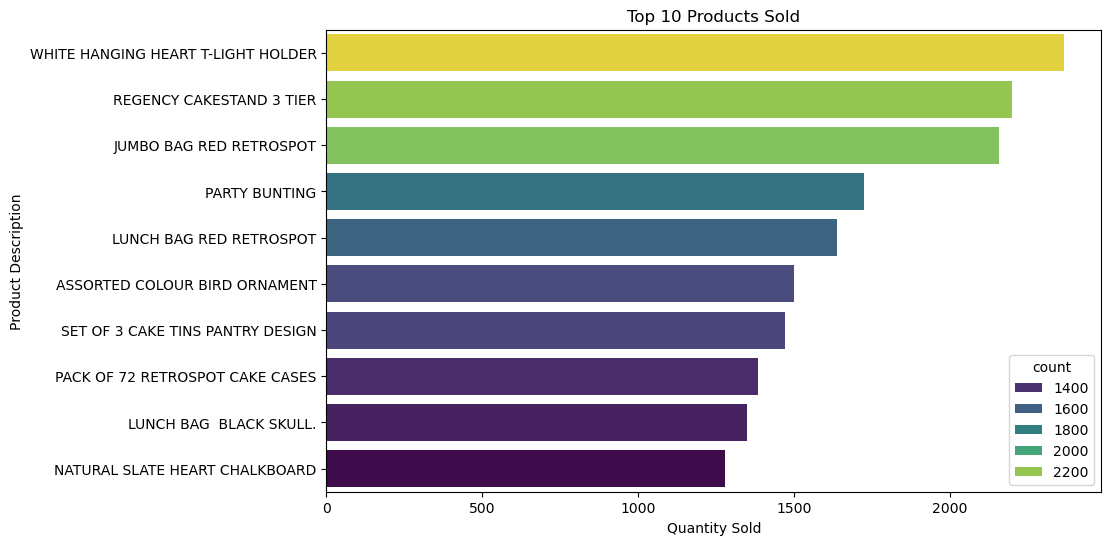

In [10]:
# Top 10 products sold
top_products = df['Description'].value_counts().head(10)

# Plot Top Products
plt.figure(figsize=(10, 6))
sns.barplot(x=top_products.values, y=top_products.index, palette='viridis',hue=top_products)
plt.title("Top 10 Products Sold")
plt.xlabel("Quantity Sold")
plt.ylabel("Product Description")
plt.show()


## EDA - Top Countries by Sales

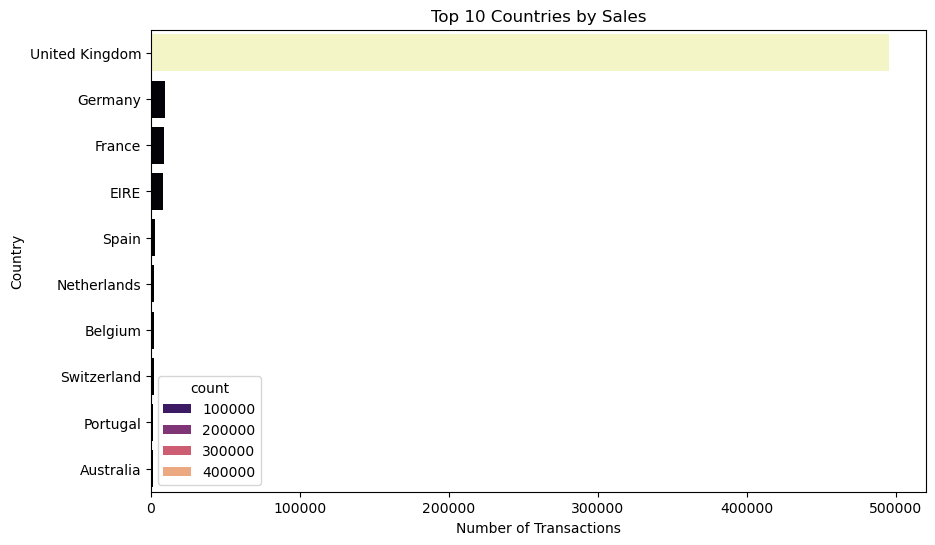

In [12]:
# Top 10 countries by sales
top_countries = df['Country'].value_counts().head(10)

# Plot Top Countries
plt.figure(figsize=(10, 6))
sns.barplot(x=top_countries.values, y=top_countries.index, palette='magma',hue=top_countries)
plt.title("Top 10 Countries by Sales")
plt.xlabel("Number of Transactions")
plt.ylabel("Country")
plt.show()


## Popularity-Based Recommendation

In [13]:
# Group products by description and calculate total quantity sold
popular_products = df.groupby('Description')['Quantity'].sum().reset_index()

# Sort products by quantity sold
popular_products = popular_products.sort_values(by='Quantity', ascending=False).head(10)

# Display top 10 popular products
print("Top 10 Popular Products:\n", popular_products)


Top 10 Popular Products:
                              Description  Quantity
3998   WORLD WAR 2 GLIDERS ASSTD DESIGNS     53847
1855             JUMBO BAG RED RETROSPOT     47363
234        ASSORTED COLOUR BIRD ORNAMENT     36381
2728                      POPCORN HOLDER     36334
2386     PACK OF 72 RETROSPOT CAKE CASES     36039
3907  WHITE HANGING HEART T-LIGHT HOLDER     35317
2791                  RABBIT NIGHT LIGHT     30680
2150              MINI PAINT SET VINTAGE     26437
2352           PACK OF 12 LONDON TISSUES     26315
2384  PACK OF 60 PINK PAISLEY CAKE CASES     24753


## Collaborative Filtering - User-Item Matrix

In [14]:
# Create a pivot table: Customers as rows, Stock Codes (Products) as columns
pivot_table = df.pivot_table(index='CustomerID', columns='StockCode', values='Quantity', fill_value=0)

# Convert pivot table to a sparse matrix
sparse_matrix = csr_matrix(pivot_table)

# Calculate cosine similarity between customers
similarity_matrix = cosine_similarity(sparse_matrix)
print("Similarity Matrix Shape:", similarity_matrix.shape)


Similarity Matrix Shape: (4372, 4372)


## Function for Collaborative Recommendations

In [21]:
# Function to recommend products based on customer similarity
def recommend_products(customer_id, pivot_table, similarity_matrix, num_recommendations=5):
    if customer_id not in pivot_table.index:
        print("Customer ID not found!")
        return
    
    # Get the customer's index
    customer_idx = pivot_table.index.get_loc(customer_id)
    
    # Find similar customers
    sim_scores = similarity_matrix[customer_idx]
    similar_customers = sorted(list(enumerate(sim_scores)), key=lambda x: x[1], reverse=True)[1:6]
    
    # Recommend products purchased by similar customers
    recommended_products = set()
    for idx, score in similar_customers:
        similar_customer_id = pivot_table.index[idx]
        purchased_products = pivot_table.columns[pivot_table.loc[similar_customer_id] > 0].tolist()
        recommended_products.update(purchased_products)
    
    # Removing already purchased products
    purchased_by_customer = pivot_table.columns[pivot_table.loc[customer_id] > 0].tolist()
    final_recommendations = [product for product in recommended_products if product not in purchased_by_customer]
    
    # Return top N recommendations
    return final_recommendations[:num_recommendations]


## Example: Collaborative Filtering Recommendation

In [16]:
# Test the recommendation function
example_customer_id = pivot_table.index[0]  # Select first customer for testing
recommendations = recommend_products(example_customer_id, pivot_table, similarity_matrix)

print(f"Recommended Products for Customer {example_customer_id}: {recommendations}")


Recommended Products for Customer 12346.0: [23552, 84992, 23559, 22550, 22551]


## Content-Based Filtering (TF-IDF)

In [17]:
# Prepare data for content-based filtering using product descriptions
product_descriptions = df.drop_duplicates(subset=['StockCode'])[['StockCode', 'Description']].dropna()

# TF-IDF Vectorization of product descriptions
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(product_descriptions['Description'])

# Calculate cosine similarity between product descriptions
product_similarity = cosine_similarity(tfidf_matrix)
print("Product Similarity Matrix Shape:", product_similarity.shape)

# Function for Content-Based Recommendations
def content_based_recommendation(stock_code, product_data, similarity_matrix, num_recommendations=5):
    product_index = product_data[product_data['StockCode'] == stock_code].index[0]
    sim_scores = list(enumerate(similarity_matrix[product_index]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)[1:num_recommendations+1]
    recommended_indices = [i[0] for i in sim_scores]
    return product_data.iloc[recommended_indices]['StockCode'].tolist()


Product Similarity Matrix Shape: (3894, 3894)


## Example: Content-Based Recommendation

In [18]:
# Test the content-based recommendation function
example_product = product_descriptions['StockCode'].iloc[0]
similar_products = content_based_recommendation(example_product, product_descriptions, product_similarity)

print(f"Products similar to {example_product}: {similar_products}")


Products similar to 85123A: ['85123a', 21733, '84970S', '84970s', 21814]
